In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modules.numeric import *
# from findiff import FinDiff

from modules.plotting import *
cmap = get_cmap()

# Using convolution for apply reflective boundary conditions

In [3]:
from scipy.ndimage import convolve, convolve1d

## Measuring and comparing the methods delay

In [5]:
C = diff_coeffs(2, (-2, -1, 0, 1, 2))
C

array([-0.08333333,  1.33333333, -2.5       ,  1.33333333, -0.08333333])

In [6]:
N = 1000
y = np.random.rand(N)

In [7]:
M = np.r_[[
    np.pad(C, (i, N-i-len(C)))
    for i in range(N-len(C)+1)
]]
M.shape

(996, 1000)

In [8]:
from matplotlib import colors

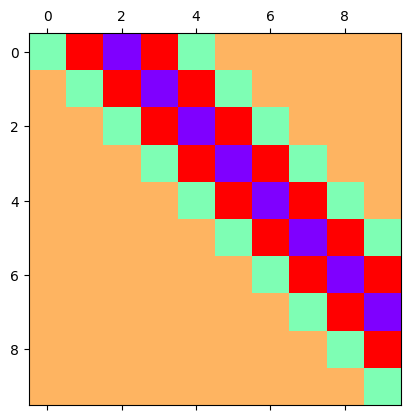

In [9]:
plt.matshow(M[:10, :10], norm=colors.BoundaryNorm(np.sort(np.r_[C, 0]), plt.get_cmap().N), cmap='rainbow')

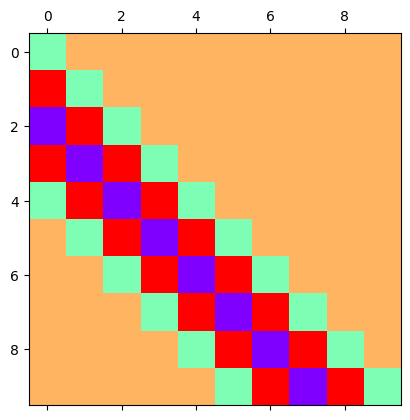

In [10]:
plt.matshow(M[-10:, -10:], norm=colors.BoundaryNorm(np.sort(np.r_[C, 0]), plt.get_cmap().N), cmap='rainbow')

In [14]:
from time import time

In [15]:
t_dot = []
t_conv = []
t_conv1d = []

Ns = np.arange(100, 5000, 50)
for i, N in enumerate(Ns):
    M = np.r_[[
        np.pad(C, (i, N-i-len(C)))
        for i in range(N-len(C)+1)
    ]]
    y = np.random.rand(N)

    m_dot = []
    m_conv = []
    m_conv1d = []
    for _ in range(50):
        tic = time()
        M.dot(y)
        tac = time()
        m_dot.append(tac-tic)

        tic = time()
        convolve(y, C, mode='reflect')
        tac = time()
        m_conv.append(tac-tic)

        tic = time()
        convolve1d(y, C, mode='reflect')
        tac = time()
        m_conv1d.append(tac-tic)

    t_dot.append((np.mean(m_dot), np.std(m_dot)))
    t_conv.append((np.mean(m_conv), np.std(m_conv)))
    t_conv1d.append((np.mean(m_conv1d), np.std(m_conv1d)))

t_dot = np.r_[t_dot]
t_conv = np.r_[t_conv]
t_conv1d = np.r_[t_conv1d]

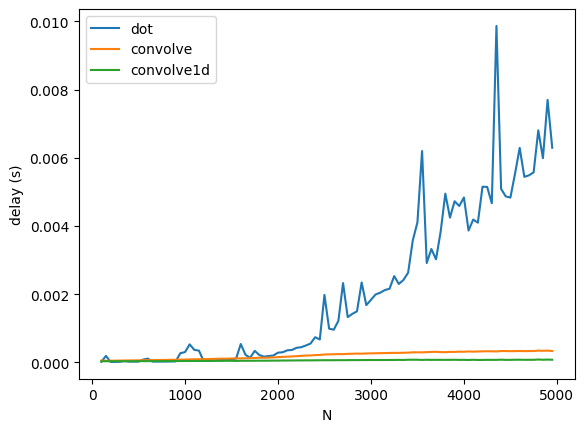

In [16]:
plt.plot(Ns, t_dot[:, 0], label='dot')
plt.plot(Ns, t_conv[:, 0], label='convolve')
plt.plot(Ns, t_conv1d[:, 0], label='convolve1d')
plt.legend()
plt.xlabel('N')
plt.ylabel('delay (s)')
plt.show()

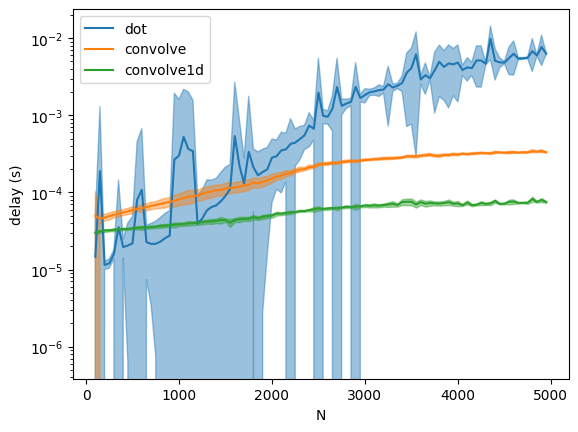

In [17]:
plt.plot(Ns, t_dot[:, 0], label='dot')
plt.plot(Ns, t_conv[:, 0], label='convolve')
plt.plot(Ns, t_conv1d[:, 0], label='convolve1d')
plt.fill_between(Ns, t_dot[:, 0] - t_dot[:, 1], t_dot[:, 0] + t_dot[:, 1], color='C0', alpha=0.45)
plt.fill_between(Ns, t_conv[:, 0] - t_conv[:, 1], t_conv[:, 0] + t_conv[:, 1], color='C1', alpha=0.45)
plt.fill_between(Ns, t_conv1d[:, 0] - t_conv1d[:, 1], t_conv1d[:, 0] + t_conv1d[:, 1], color='C2', alpha=0.45)
plt.semilogy()
plt.legend()
plt.xlabel('N')
plt.ylabel('delay (s)')
plt.show()

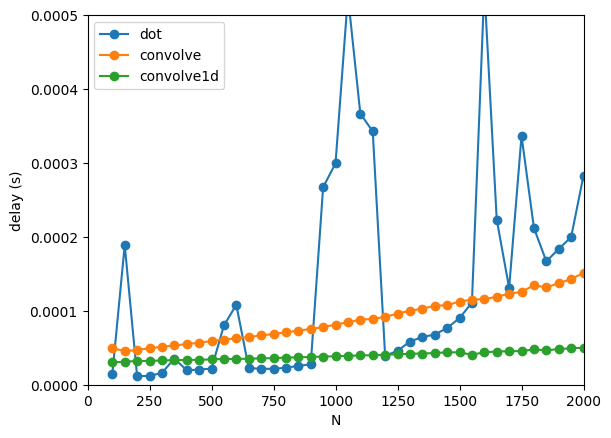

In [18]:
plt.plot(Ns, t_dot[:, 0], '-o', label='dot')
plt.plot(Ns, t_conv[:, 0], '-o', label='convolve')
plt.plot(Ns, t_conv1d[:, 0], '-o', label='convolve1d')
plt.legend()
plt.xlabel('N')
plt.ylabel('delay (s)')
plt.ylim(0, 0.0005)
plt.xlim(0, 2000)
plt.show()

## Testing

In [4]:
L = 40
N = (L/40)*1000
dx = 2*L/(N - 1)
dt = 0.7*dx
x_range = (-L, L + dx, dx)

In [5]:
order = 4
x = np.arange(*x_range)
p = order + 2
D2x = diff_coeffs(2, np.arange(p) - p//2, h=x_range[-1])
def F(t, Y, lamb):
    y, dy_dt = Y
    return np.stack((
        dy_dt, # = dy(t)
        convolve1d(y, D2x, mode='reflect') + lamb*y*(1 - y**2) # = ddy(t)
    ))

In [6]:
lamb = 2
x0 = 10*Kink.delta(lamb)/2

collider = KinkCollider(x_range, x0s=(-x0, x0), dt=dt, order=4)
collider.F = F

In [7]:
v = 0.2447
lat, Y = collider.collide(vs=(v, -v), lamb=lamb, t_final=x0/v +3*L)

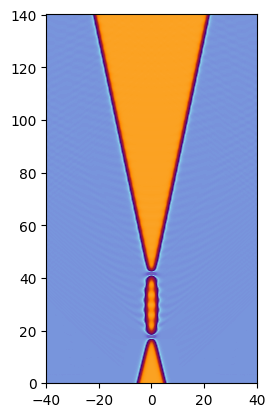

In [8]:
plt.imshow(Y[:, 0], extent=(lat.x.min(), lat.x.max(), lat.t.min(), lat.t.max()), cmap=cmap, vmin=-2, vmax=2, origin='lower')
plt.show()

### Ressonance

In [9]:
from multiprocessing import Pool
from pathlib import Path

save_dir = Path('data/session-experiment-lamb=2')
# save_dir.mkdir(exist_ok=True)

# vs = np.linspace(0.18, 0.3, 2000)
# vs = np.linspace(0.15, 0.27, 2000)
V_in = np.sort(np.stack([float(filename.stem) for filename in save_dir.glob('*.csv')]))
lamb = 2

#### Data

In [10]:
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [103]:
def get_bounces(y_cm, loc=False):
    w = 1 - y_cm
    peaks, _ = find_peaks(w, height=2)
    n_bounces = len(peaks)
    cycles = [len(find_peaks(w[p1:p2])[0]) for p1, p2 in zip(peaks[:-1], peaks[1:])] if n_bounces > 1 else []
    return [n_bounces, cycles] + ([peaks] if loc else [])

def velocity(trail, dt: float=1):
    leap = np.squeeze(np.argwhere(np.diff(trail) != 0))[-len(trail)//2:][::-1]
    # curve = interp.BSpline(*interp.splrep(leap*dt, trail[leap])) #.derivative(1) 
    return np.mean(np.diff(trail[leap])/(np.diff(leap)*dt)) #float(curve(leap[-2]*dt, 1))

def clump_invalid(a):
    return [a[s] for s in np.ma.clump_unmasked(np.ma.masked_invalid(a))]

def task(v):
    filename = save_dir/f'{v}.csv'
    y_cm, trail = np.loadtxt(filename, delimiter=',')
    n_bounces, cycles, peaks = get_bounces(y_cm, loc=True)

    if len(peaks) > 1:
        T12 = (peaks[1]-peaks[0])*dt
    else: T12 = np.nan

    try: v_out = velocity(clump_invalid(trail)[-1], dt)
    except: v_out = 0
    return v_out, n_bounces, cycles[0] if len(cycles) else 0, T12

with Pool(processes=20) as pool:
    data = pool.map(task, V_in)

/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice

/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice

In [69]:
V_out, n_bounces, cycles, T12 = np.transpose(data)

#### Analysis

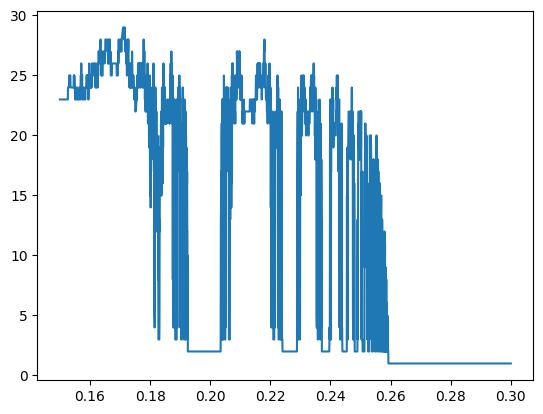

In [13]:
# n_bounces = np.stack([n_b for n_b, _, _ in bounces])
# two_mini_bounces = np.stack([mini_bounces[0] if len(mini_bounces) > 0 else 0 for _, mini_bounces, _ in bounces])
plt.plot(V_in, n_bounces)
# plt.plot(vs, two_mini_bounces)
plt.show()

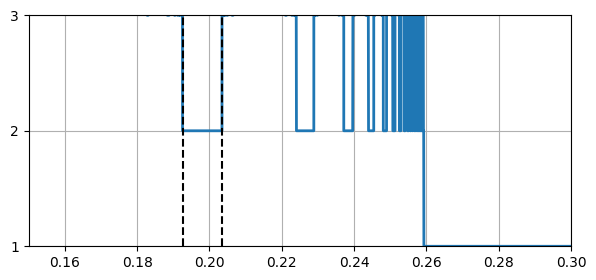

In [115]:
plt.figure(figsize=(7, 3))

plt.plot(V_in, n_bounces, lw=2)

for v in (0.192575, 0.20342):
    plt.axvline(v, ls='--', c='k')

plt.ylim(1, 3)
plt.xlim(0.15, 0.3)
plt.yticks((1, 2, 3))
plt.grid()
plt.show()

In [134]:
wds = [] # m, v_min, v_max
loc = (n_bounces == 2)
for m in np.unique(cycles[loc]):
    if m <= 5:
        v_range = V_in[loc & (cycles == m)]
        wds.append((m, v_range.min(), v_range.max()))
wds = pd.DataFrame(wds, columns=('m', 'v_min', 'v_max'))
wds['dv'] = wds.v_max - wds.v_min
wds['dv1'] = wds.dv/float(wds.dv[wds.m == 1])

M = wds.m + 2
M1 = 1 + 2
wds['beta'] = -np.log(wds.dv/float(wds.dv[wds.m == 1]))/np.log(M/M1)

wds

/tmp/ipykernel_3336984/2836976041.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  wds['dv1'] = wds.dv/float(wds.dv[wds.m == 1])
/tmp/ipykernel_3336984/2836976041.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  wds['beta'] = -np.log(wds.dv/float(wds.dv[wds.m == 1]))/np.log(M/M1)


,m,v_min,v_max,dv,dv1,beta
0,1.0,0.192546,0.203472,0.010925,1.000000,NaN
1,2.0,0.224062,0.228864,0.004802,0.439560,2.857252
2,3.0,0.237149,0.239610,0.002461,0.225275,2.917697
3,4.0,0.243992,0.245433,0.001441,0.131868,2.922832
4,5.0,0.248074,0.248974,0.000900,0.082418,2.945784


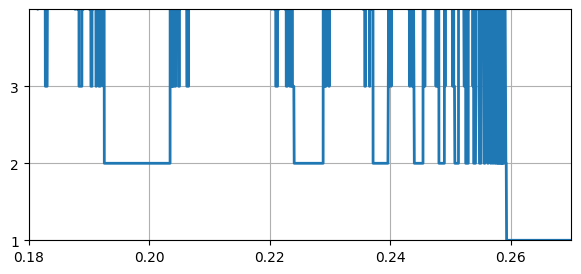

In [18]:
plt.figure(figsize=(7, 3))
plt.plot(V_in, n_bounces, lw=2)
plt.ylim(1, 4)
plt.xlim(0.18, 0.27)
plt.yticks((1, 2, 3))
plt.grid()
plt.show()

In [22]:
from matplotlib import patches

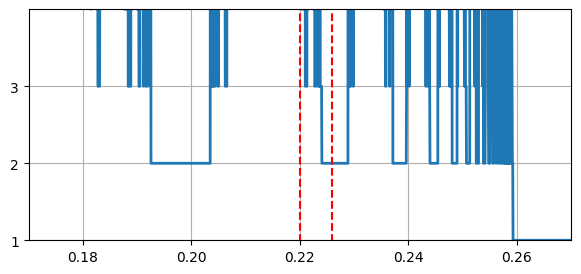

In [55]:
plt.figure(figsize=(7, 3))
plt.plot(V_in, n_bounces, lw=2)
plt.ylim(1, 4)
plt.xlim(0.17, 0.27)
plt.yticks((1, 2, 3))

l, r = 0.22, 0.226
# plt.gca().add_patch(patches.Rectangle((l, 1.9), r-l, 4, fill=False, color='r', zorder=np.inf, lw=1.2, ls='--'))
plt.vlines((l, r), 0, 4, lw=[1.5]*2, color='r', linestyle='dashed')

plt.grid()
plt.show()

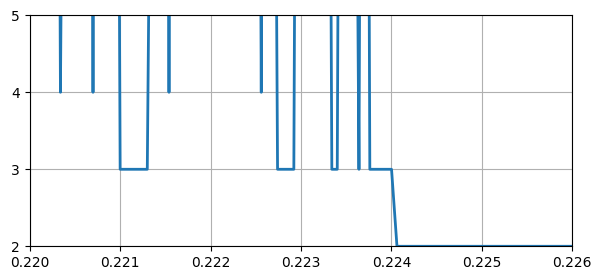

In [56]:
plt.figure(figsize=(7, 3))
plt.plot(V_in, n_bounces, lw=2)
plt.ylim(2, 5)
plt.xlim(l, r)
plt.yticks((2, 3, 4, 5))
plt.grid()
plt.show()

(3.745563745569735, 0.0028220398466817036)

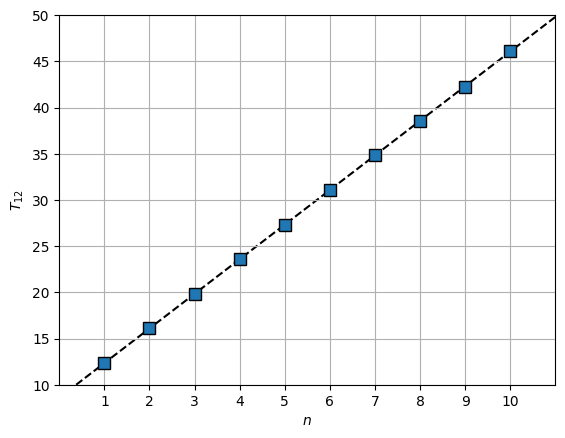

In [66]:
def linear(x, a, b):
    return a*x + b

loc1 = n_bounces == 2
loc2 = np.r_[True, np.diff(cycles[loc1]) != 0] & (cycles[loc1] <= 10)
cycles_ = cycles[loc1][loc2]
T12_ = T12[loc1][loc2]

plt.plot(cycles_, T12_, 's', markeredgecolor='k', markersize=8)

(a, b), pcov = curve_fit(linear, cycles_, T12_)
plt.axline((0, b), slope=a, color='k', ls='--', zorder=0)
# ns_ = np.linspace(cycles_.min(), cycles_.max(), 25)
# plt.plot(ns_, linear(ns_, a, b), 'k--', zorder=-1)

plt.xticks(cycles_)
plt.xlim(0, 11)
plt.ylim(10, 50)
plt.grid()
plt.xlabel(r'$n$')
plt.ylabel(r'$T_{12}$')

a, np.sqrt(np.diag(pcov))[0]

Text(0, 0.5, '$T_{12}$')

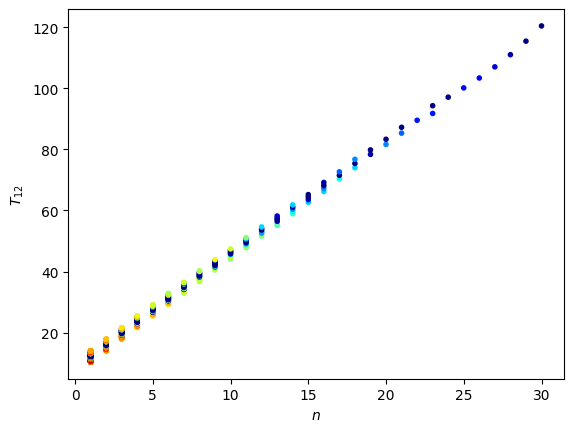

In [77]:
plt.scatter(cycles, T12, marker='.', c=n_bounces, cmap='jet')

# plt.xticks(np.unique(cycles))
plt.xlabel(r'$n$')
plt.ylabel(r'$T_{12}$')

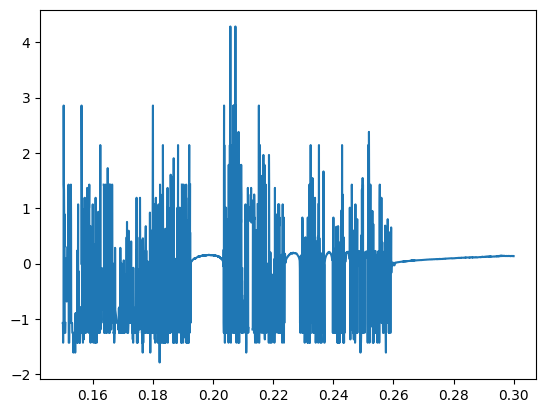

In [104]:
plt.plot(V_in, V_out)

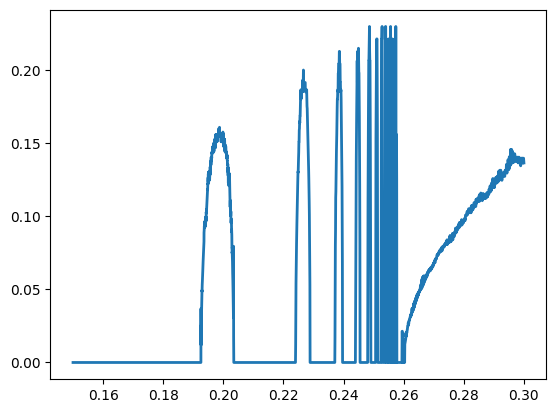

In [110]:
loc1 = np.isin(n_bounces, (1, 2)) & (cycles <= 15) & (V_out >= 0)
# loc2 = n_bounces > 1
plt.plot(V_in, np.where(loc1, V_out, 0), lw=2)
# plt.plot(V_in[~loc2][::5], np.abs(V_out[~loc2][::5]), lw=2)

In [97]:
one_bounce = n_bounces == 1
np.argwhere(V_out == V_out[one_bounce].min())

array([[2287]])

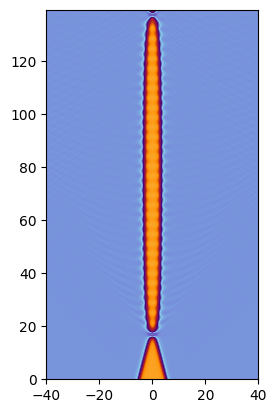

In [100]:
v = V_in[2286]
lat, Y = collider.collide(vs=(v, -v), lamb=lamb, t_final=x0/v +3*L)
plt.imshow(Y[:, 0], extent=(lat.x.min(), lat.x.max(), lat.t.min(), lat.t.max()), cmap=cmap, vmin=-2, vmax=2, origin='lower')
plt.show()

In [13]:
Dx = diff_coeffs(1, np.arange(6)-3, h=dx)
def V(y):
    return lamb*(y**2 - 1)**2/4

def energy_density(Yi):
    return np.stack([(convolve1d(yi[0], Dx, mode='reflect')**2 + yi[1]**2)/2 + V(yi[0]) for yi in Yi])

def get_trail(x, Yi):
    trail = []
    for y in Yi[:, 0]:
        plateau = y >= 0
        if np.any(plateau): trail.append(x[plateau].max())
        else: trail.append(np.nan)
    return np.r_[trail]

def using_clump(a):
    return [a[s] for s in np.ma.clump_unmasked(np.ma.masked_invalid(a))]

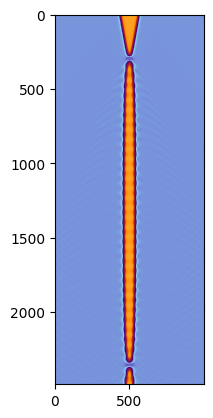

In [100]:
plt.imshow(Y[1319][:, 0], cmap=cmap, vmin=-2, vmax=2)

In [19]:
from scipy import interpolate as interp

array(-0.37628511)

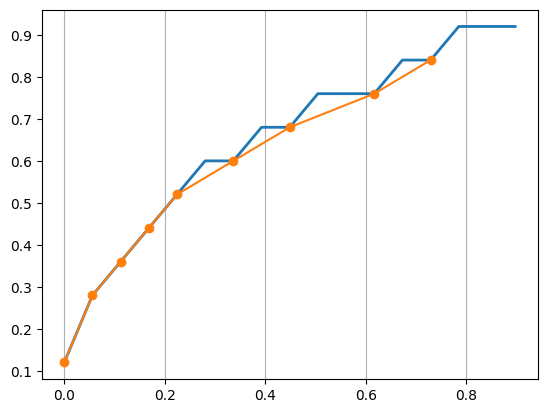

In [105]:
trail = using_clump(get_trail(x, Y[1320]))[-1]
leap = np.squeeze(np.argwhere(np.diff(trail) != 0))
t = np.arange(len(trail))
plt.plot(t*dt, trail, lw=2)
plt.plot(leap*dt, trail[leap], '-o')

# poly = interp.lagrange(leap*dt, trail[leap])
# T = np.linspace(0, len(trail), 25)*dt
# plt.plot(T, poly(T), 'k--')

# curve = interp.BSpline(*interp.splrep(leap*dt, trail[leap]))
# T = np.linspace(0, len(trail), 25)*dt
# plt.plot(T, curve(T), 'k--')

# plt.plot(T, curve(T, 1), 'r--')

plt.grid(axis='x')
# plt.xticks(leap*dt, [])
curve(leap[-1]*dt, 1)

In [12]:
vDx = diff_coeffs(1, -np.arange(6), h=dx)

def velocity(trail, dt: float=1):
    leap = np.squeeze(np.argwhere(np.diff(trail) != 0))[-5:][::-1]
    # curve = interp.BSpline(*interp.splrep(leap*dt, trail[leap])) #.derivative(1) 
    return np.mean(np.diff(trail[leap])/(np.diff(leap)*dt)) #float(curve(leap[-2]*dt, 1))

def analysis(Yi):
    try: v_out = velocity(using_clump(get_trail(x, Yi))[-1], dt)
    except: v_out = 0
    # n = len(find_peaks(1 - y[:, cm_index], prominence=0.5)[0])
    return v_out

# V_out = np.stack(tuple(map(analysis, Y)))

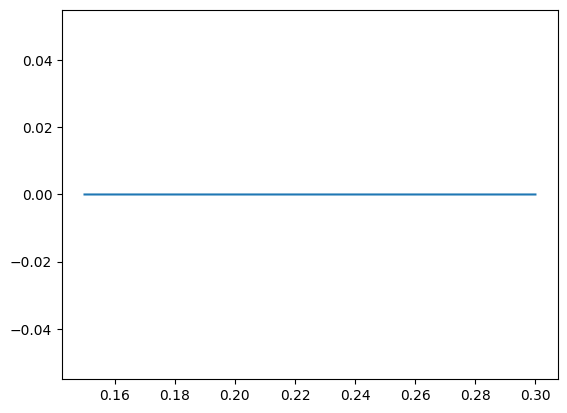

In [25]:
plt.plot(vs, V_out)

In [60]:
np.unique(two_mini_bounces)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

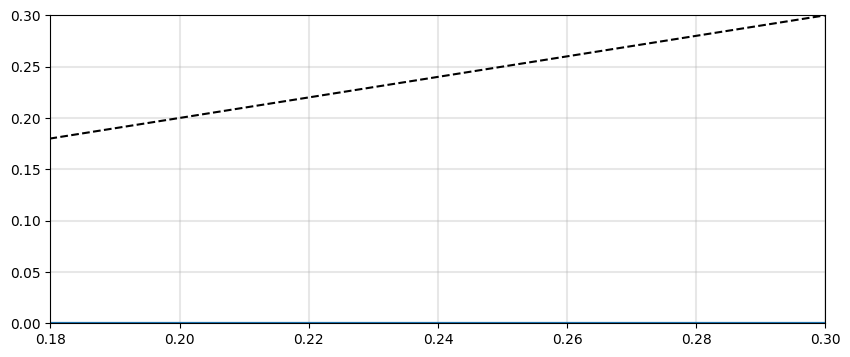

In [26]:
plt.figure(figsize=(10, 4))

loc = (n_bounces == 2) & (two_mini_bounces < 30)
plt.plot(vs[::2], np.where(loc, V_out, 0)[::2], lw=2)

loc = n_bounces == 1
plt.plot(vs[loc][::5], V_out[loc][::5], c='C0', lw=2)

plt.plot(vs, vs, 'k--')
plt.xlim(0.18, 0.3)
plt.ylim(0, 0.3)
# plt.gca().set_aspect('equal')
plt.grid(alpha=0.3, lw=1.5)
plt.show()

In [104]:
np.argwhere(two_mini_bounces == 30)

array([[1320]])

In [ ]:
)
plt.plot(vs[::10], np.where((n_bounces == 1), V_out, 0)[::10])

plt.plot(vs, vs, 'k--')
plt.xlim(0.18, 0.3)
plt.ylim(0, 0.3)
# plt.gca().set_aspect('equal')
plt.grid(alpha=0.3, lw=1.5)
plt.show()

In [59]:
np.squeeze(np.argwhere(np.where((np.r_[n_bounces] == 2) & (np.r_[V_out] >= 0), V_out, 0) > 0.3))

array(1320)

### Trying kink-boundary $\phi^4$

In [394]:
def coth(x):
    return np.cosh(x)/np.sinh(x)

def get_y0(x, v, H, x0=-10):
    gamma = 1/np.sqrt(1 - v**2)
    if H > 0:
        X0 = np.arccosh(1/np.sqrt(np.abs(H)))
        y1 = np.tanh(x - X0)
        y0 = y1 - np.tanh(gamma*(x - x0)) + 1
    else:
        X1 = np.arctanh(1/np.sqrt(1-H)) #np.arcsinh(1/np.sqrt(np.abs(H)))
        y3 = -coth(x - X1)
        y0 = -y3 - np.tanh(gamma*(x - x0)) + 1
    return np.stack((
        y0,
        gamma*v/np.cosh(gamma*(x - x0))**2
    ))

L = 100
N = 1024
dx = L/(N-1)
dt = 0.04

In [481]:
order = 4
p = order + 2
D2x = diff_coeffs(2, np.r_[-2, -1, 0, 1, 2], h=dx)

def F(t, Y, lamb, H):
    y, dy_dt = Y
    d2y_dx2 = convolve1d(y, D2x, mode='constant')

    d2y_dx2[-1] = -(np.r_[85, -108, 27, -4].dot(y[-4:][::-1]) + 66*dx*H)/(18*dx**2)
    d2y_dx2[-2] = (np.r_[29, -54, 27, -2].dot(y[-4:][::-1]) + 6*dx*H)/(18*dx**2)

    return np.stack((
        dy_dt, # = dy(t)
        d2y_dx2 + lamb*y*(1 - y**2) # = ddy(t)
    ))

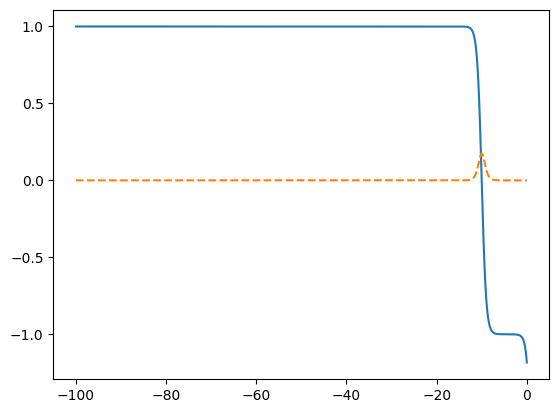

In [482]:
x0 = -10
v = 0.17149
H = -0.4

x = np.linspace(-L, 0, N)
y0 = get_y0(x, v, H, x0)
plt.plot(x, y0[0], x, y0[1], '--')
plt.show()

In [493]:
t, Y = rk4_solve(partial(F, lamb=2, H=H), y0, dt, t_final=2*L)

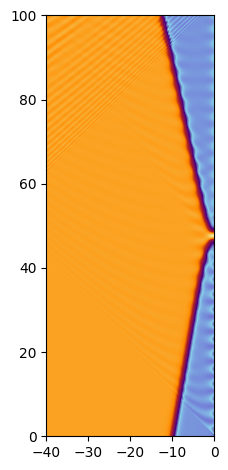

In [494]:
plt.imshow(Y[:, 0], cmap=cmap, vmin=-2, vmax=2, extent=(x.min(), x.max(), t.min(), t.max()), origin='lower')
plt.xlim(-40, 0)
plt.ylim(0, 100)
plt.gcf().tight_layout()

In [262]:
import numpy as np
from math import factorial
import sympy as sp

In [83]:
dx = sp.symbols(r'\Delta')
mu = 1
m = 2
order = 4
p = order + m
H = sp.symbols('H')

In [169]:
alpha = np.arange(p)
alpha

array([0, 1, 2, 3, 4, 5])

In [170]:
k = np.arange(p)
# alpha = alpha[k != mu]
V = sp.Matrix(alpha[k != mu][:, np.newaxis]**k[k != mu])
V

Matrix([
[1,  0,   0,   0,    0],
[1,  4,   8,  16,   32],
[1,  9,  27,  81,  243],
[1, 16,  64, 256, 1024],
[1, 25, 125, 625, 3125]])

In [172]:
gamma_m = V.inv()[m, :]
gamma_m

Matrix([[4627/7200, -47/24, 19/9, -31/32, 13/75]])

In [173]:
Dm = (factorial(m)/dx**m)*gamma_m
Dm

Matrix([[4627/(3600*\Delta**2), -47/(12*\Delta**2), 38/(9*\Delta**2), -31/(16*\Delta**2), 26/(75*\Delta**2)]])

In [174]:
Hmu_m = (dx**mu/factorial(mu))*H
Hmu_m

H*\Delta

In [178]:
S = sp.Matrix([sp.symbols(r'\phi_{%s}'%i) for i in alpha[k != mu]])
S

Matrix([
[\phi_{0}],
[\phi_{2}],
[\phi_{3}],
[\phi_{4}],
[\phi_{5}]])

In [181]:
a = sp.Matrix(alpha[k != mu])
a

Matrix([
[0],
[2],
[3],
[4],
[5]])

In [182]:
D = Dm*(S - (Hmu_m*a).applyfunc(lambda x: x**mu))
D

Matrix([[4627*\phi_{0}/(3600*\Delta**2) + 26*(-5*H*\Delta + \phi_{5})/(75*\Delta**2) - 31*(-4*H*\Delta + \phi_{4})/(16*\Delta**2) + 38*(-3*H*\Delta + \phi_{3})/(9*\Delta**2) - 47*(-2*H*\Delta + \phi_{2})/(12*\Delta**2)]])

In [183]:
D[0].simplify()

(4260*H*\Delta + 4627*\phi_{0} - 14100*\phi_{2} + 15200*\phi_{3} - 6975*\phi_{4} + 1248*\phi_{5})/(3600*\Delta**2)